In [1]:
from DataParser import DataParser
import numpy as np
import pandas as pd
import scipy.sparse as sp

from Base.Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import \
split_train_in_two_percentage_global_sample

from KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from Base.NonPersonalizedRecommender import TopPop
from SLIM_ElasticNet.SLIMElasticNetRecommender import SLIMElasticNetRecommender
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.rcParams.update({'font.size': 40})

%matplotlib inline

In [2]:
seed = 1024
parser = DataParser()

URM_all = parser.get_URM_all()
ICM_all = parser.get_ICM_all()

URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage=0.85, seed=seed)

evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

In [3]:
mat = URM_all.tocoo()
d={'user_id':mat.row,
   'item_id':mat.col,
   'rating':mat.data}
frame = pd.DataFrame(data=d)
frame_n = frame.groupby(['user_id']).size().reset_index(name='num_inter')

In [4]:
#frame_n.loc[frame_n['num_inter'] < 2]

In [5]:
mat = URM_train.tocoo()
d={'user_id':mat.row,
   'item_id':mat.col,
   'rating':mat.data}
frame = pd.DataFrame(data=d)
frame_train = frame.groupby(['user_id']).size().reset_index(name='num_inter')

mat = URM_test.tocoo()
d={'user_id':mat.row,
   'item_id':mat.col,
   'rating':mat.data}
frame_test = pd.DataFrame(data=d)
frame_join = frame_test.join(frame_train.set_index('user_id'), on='user_id')
#frame_join

In [6]:
def split_datasets(frame, size = 20):
    max_value = frame['num_inter'].max()
    frame_list=[]
    start_value = 0
    while start_value <= max_value:
        end_value = start_value+size
        sub_frame = frame_join.loc[(frame_join['num_inter'] >= start_value) & (frame_join['num_inter'] < end_value)].iloc[:,:3]
        if not sub_frame.empty:
            t = (start_value, end_value, sub_frame)
        else:
            t = (start_value, end_value, None)
        frame_list.append(t)
        start_value = end_value
    return frame_list

In [45]:
def compute_map_per_range(recommender, URM_test, range_size=20, limit=None):
    map_list=[]
    
    URM_train = recommender.get_URM_train()
    mat = URM_train.tocoo()
    d={'user_id':mat.row,
       'item_id':mat.col,
       'rating':mat.data}
    frame = pd.DataFrame(data=d)
    frame_train = frame.groupby(['user_id']).size().reset_index(name='num_inter')

    mat = URM_test.tocoo()
    d={'user_id':mat.row,
       'item_id':mat.col,
       'rating':mat.data}
    frame_test = pd.DataFrame(data=d)
    frame_join = frame_test.join(frame_train.set_index('user_id'), on='user_id')
    
    frame_list = split_datasets(frame_join, range_size)
    
    for (start_value, end_value, sub_frame) in frame_list[:limit]:
        if sub_frame is None:
            frame_map = None
            frame_len = None
        else:
            frame_len = len(sub_frame.user_id.unique())
            partial_urm_test = sp.csr_matrix((sub_frame.rating, (sub_frame.user_id, sub_frame.item_id)), 
                              shape=URM_train.shape)
            evaluator_test = EvaluatorHoldout(partial_urm_test, cutoff_list=[10])
            result, _ = evaluator_test.evaluateRecommender(recommender)
            frame_map = result[10]['MAP']
        map_list.append((start_value, end_value, frame_map, frame_len))
    
    return map_list
    

In [8]:
def frame_to_plot(map_list):
    x = []
    y = []
    z = []
    for (low, high, val, support) in map_list:
        x_val = str(low)+'-'+str(high)
        if val is None:
            #y.append(0)
            continue
        else:
            y.append(val)
        x.append(x_val)
        z.append(support)
    return x,y,z

In [9]:
def plot_frame(x,y):
    #figure(num=None, figsize=(100, 20), dpi=80, facecolor='w', edgecolor='k')
    #igure(figsize=(50,20))
    axes = plt.gca()
    #axis_font = {'fontname':'Arial', 'size':'22'}
    #axes.set_ylim([0,0.3])
    #axes.tick_params(axis='both', labelsize='large')
    plt.setp(axes.get_xticklabels(), rotation='vertical', fontsize=14)
    
    plt.bar(x, y) #, align='center'
    plt.xticks(range(len(x)), x)

In [87]:
def multiplot_frame(maps):
    plt.style.use('seaborn-deep')
    figure(num=None, figsize=(30, 6), dpi=80, facecolor='w', edgecolor='k')
    axes = plt.gca()
    axes.set_ylim([0,0.6])
    clabel= 0
    for x, y in maps:
        plt.bar(range(len(x)), list(y), align='center', label = str(clabel))
        clabel+=1
    plt.legend()
    plt.xticks(range(len(x)), list(list(x)))

In [108]:
def multiplot_frame2(maps):
    plt.style.use('seaborn-deep')
    figure(num=None, figsize=(30, 6), dpi=80, facecolor='w', edgecolor='k')
    axes = plt.gca()
    axes.set_ylim([0,0.6])
    clabel= 0
    plt.bar(range(len(maps[0][0])), list(maps[0][1]), align='center')
    clabel+=1
    rects = axes.patches

    # Make some labels.
    labels = maps[0][2]

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        axes.text(rect.get_x() + rect.get_width()/2, height, label, ha='center', va='bottom')
    plt.xticks(range(len(maps[0][0])), list(list(maps[0][0])))

In [129]:
def max_rec_map(maps):
    y_max=[(0,0) for x in range(len(x_mf))]
    c=0
    for _, y in maps:
        for n, val in enumerate(y):
            if val > y_max[n][0]:
                y_max[n] = (val,c)
        c+=1
    y_max,c = zip(*y_max)
    list(y_max)
    c = [x for x in c]
    #fill the name in the same order of appearance in the maps list
    for n in range(len(c)):
        if c[n]==0:
            c[n]='itemCF'
        elif c[n]==1:
            c[n]='itemCBF'
        elif c[n]==2:
            c[n]='PageRankBB'
        elif c[n]==3:
            c[n]='SlimBPR'
        elif c[n]==4:
            c[n]='userCF'
        elif c[n]==5:
            c[n]='PageRankAA'
    c = list(c)
    return y_max, c

In [10]:
rec1 = ItemKNNCBFRecommender(URM_train, ICM_all)
rec1.fit(topK=40, shrink=1000, similarity='cosine', feature_weighting='BM25')
result_eval, _ = evaluator_test.evaluateRecommender(rec1) 

ItemKNNCBFRecommender: URM Detected 42 (0.53 %) cold users.
ItemKNNCBFRecommender: URM Detected 1971 (7.59 %) cold items.
Similarity column 25975 ( 100 % ), 4793.13 column/sec, elapsed time 0.09 min
EvaluatorHoldout: Processed 5002 ( 100.00% ) in 2.69 sec. Users per second: 1863


In [11]:
map_list_knn = compute_map_per_range(rec1, URM_test, range_size=30)
x_knn,y_knn,_ = frame_to_plot(map_list_knn)
frame_knn = pd.DataFrame({'range':x_knn, 'MAP':y_knn})
#frame_knn

EvaluatorHoldout: Processed 4362 ( 100.00% ) in 2.23 sec. Users per second: 1952
EvaluatorHoldout: Processed 368 ( 100.00% ) in 0.23 sec. Users per second: 1616
EvaluatorHoldout: Processed 104 ( 100.00% ) in 0.08 sec. Users per second: 1284
EvaluatorHoldout: Processed 41 ( 100.00% ) in 0.03 sec. Users per second: 1171
EvaluatorHoldout: Processed 23 ( 100.00% ) in 0.02 sec. Users per second: 1000
EvaluatorHoldout: Processed 19 ( 100.00% ) in 0.02 sec. Users per second: 1000
EvaluatorHoldout: Processed 15 ( 100.00% ) in 0.02 sec. Users per second: 882
EvaluatorHoldout: Processed 5 ( 100.00% ) in 0.01 sec. Users per second: 556
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 429
EvaluatorHoldout: Processed 5 ( 100.00% ) in 0.01 sec. Users per second: 556
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.00 sec. Users per second: 200
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.01 sec. Users per second: 333


C:\Users\gio_d\Documents\Projects\RecSys\RecSys-2020\Base\Evaluation\metrics.py:947: RuntimeWarning: invalid value encountered in double_scalars
  self.diversity = diversity_cumulative/all_user_couples_count


EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 429
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 167
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.01 sec. Users per second: 250
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 143
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.01 sec. Users per second: 286
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 143
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.00 sec. Users per second: 200
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 143


In [12]:
rec_elasticnet = SLIMElasticNetRecommender(URM_train)
rec_elasticnet.fit(topK=120, l1_ratio=1e-5, alpha=0.066)


SLIMElasticNetRecommender: URM Detected 42 (0.53 %) cold users.
SLIMElasticNetRecommender: URM Detected 1971 (7.59 %) cold items.
SLIMElasticNetRecommender: Processed 9406 ( 36.21% ) in 5.00 min. Items per second: 31.35
SLIMElasticNetRecommender: Processed 19151 ( 73.73% ) in 10.00 min. Items per second: 31.92
SLIMElasticNetRecommender: Processed 25975 ( 100.00% ) in 13.55 min. Items per second: 31.95


In [13]:
mappone = compute_map_per_range(rec_elasticnet, URM_test, range_size=30)
x_slim,y_slim,_ = frame_to_plot(mappone)

EvaluatorHoldout: Processed 4362 ( 100.00% ) in 2.44 sec. Users per second: 1787
EvaluatorHoldout: Processed 368 ( 100.00% ) in 0.26 sec. Users per second: 1401
EvaluatorHoldout: Processed 104 ( 100.00% ) in 0.09 sec. Users per second: 1118
EvaluatorHoldout: Processed 41 ( 100.00% ) in 0.04 sec. Users per second: 1108
EvaluatorHoldout: Processed 23 ( 100.00% ) in 0.02 sec. Users per second: 920
EvaluatorHoldout: Processed 19 ( 100.00% ) in 0.03 sec. Users per second: 729
EvaluatorHoldout: Processed 15 ( 100.00% ) in 0.02 sec. Users per second: 790
EvaluatorHoldout: Processed 5 ( 100.00% ) in 0.01 sec. Users per second: 502
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 429
EvaluatorHoldout: Processed 5 ( 100.00% ) in 0.01 sec. Users per second: 417
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 143
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.01 sec. Users per second: 334


C:\Users\gio_d\Documents\Projects\RecSys\RecSys-2020\Base\Evaluation\metrics.py:947: RuntimeWarning: invalid value encountered in double_scalars
  self.diversity = diversity_cumulative/all_user_couples_count


EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 375
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.00 sec. Users per second: 200
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.01 sec. Users per second: 286
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.00 sec. Users per second: 200
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.01 sec. Users per second: 286
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 167
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 167
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.00 sec. Users per second: 200


In [14]:
from GraphBased.RP3betaRecommender import RP3betaRecommender
recommender_apr = RP3betaRecommender(URM_train)
recommender_apr.fit(alpha=0.4530815441932864,  beta=0.008742088319964482, topK=104, normalize_similarity=False)

RP3betaRecommender: URM Detected 42 (0.53 %) cold users.
RP3betaRecommender: URM Detected 1971 (7.59 %) cold items.


In [15]:
list2=compute_map_per_range(recommender_apr, URM_test, range_size=30)
x_apr,y_apr,_ = frame_to_plot(list2)
#pd.DataFrame({'range':x, 'MAP':y})

EvaluatorHoldout: Processed 4362 ( 100.00% ) in 2.39 sec. Users per second: 1823
EvaluatorHoldout: Processed 368 ( 100.00% ) in 0.22 sec. Users per second: 1706
EvaluatorHoldout: Processed 104 ( 100.00% ) in 0.07 sec. Users per second: 1550
EvaluatorHoldout: Processed 41 ( 100.00% ) in 0.03 sec. Users per second: 1321
EvaluatorHoldout: Processed 23 ( 100.00% ) in 0.02 sec. Users per second: 1045
EvaluatorHoldout: Processed 19 ( 100.00% ) in 0.02 sec. Users per second: 998
EvaluatorHoldout: Processed 15 ( 100.00% ) in 0.01 sec. Users per second: 1000
EvaluatorHoldout: Processed 5 ( 100.00% ) in 0.01 sec. Users per second: 624
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 500
EvaluatorHoldout: Processed 5 ( 100.00% ) in 0.01 sec. Users per second: 625
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 166
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.00 sec. Users per second: 400
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. User

In [123]:
from GraphBased.P3alphaRecommender import P3alphaRecommender
recommender_alph = P3alphaRecommender(URM_train)
recommender_alph.fit(alpha=0.4905425214201532, topK=1000, normalize_similarity=False)

P3alphaRecommender: URM Detected 42 (0.53 %) cold users.
P3alphaRecommender: URM Detected 1971 (7.59 %) cold items.


In [124]:
list_alph=compute_map_per_range(recommender_alph, URM_test, range_size=30)
x_alph,y_alph,_= frame_to_plot(list_alph)

EvaluatorHoldout: Processed 4362 ( 100.00% ) in 2.40 sec. Users per second: 1818
EvaluatorHoldout: Processed 368 ( 100.00% ) in 0.26 sec. Users per second: 1389
EvaluatorHoldout: Processed 104 ( 100.00% ) in 0.09 sec. Users per second: 1109
EvaluatorHoldout: Processed 41 ( 100.00% ) in 0.04 sec. Users per second: 976
EvaluatorHoldout: Processed 23 ( 100.00% ) in 0.03 sec. Users per second: 793
EvaluatorHoldout: Processed 19 ( 100.00% ) in 0.03 sec. Users per second: 730
EvaluatorHoldout: Processed 15 ( 100.00% ) in 0.02 sec. Users per second: 682
EvaluatorHoldout: Processed 5 ( 100.00% ) in 0.01 sec. Users per second: 499
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 333
EvaluatorHoldout: Processed 5 ( 100.00% ) in 0.01 sec. Users per second: 501
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 198
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.01 sec. Users per second: 286


C:\Users\gio_d\Documents\Projects\RecSys\RecSys-2020\Base\Evaluation\metrics.py:947: RuntimeWarning: invalid value encountered in double_scalars
  self.diversity = diversity_cumulative/all_user_couples_count


EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 299
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 143
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.01 sec. Users per second: 250
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 143
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.01 sec. Users per second: 250
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 143
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 125
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 125


In [16]:
from KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
#'topK': 967, 'shrink': 356, 'similarity': 'cosine', 'normalize': True
recommender_cf_knn = ItemKNNCFRecommender(URM_train)
recommender_cf_knn.fit(topK=967, shrink=356, similarity='cosine', normalize=True)

ItemKNNCFRecommender: URM Detected 42 (0.53 %) cold users.
ItemKNNCFRecommender: URM Detected 1971 (7.59 %) cold items.
Similarity column 25975 ( 100 % ), 6459.74 column/sec, elapsed time 0.07 min


In [50]:
list_cf=compute_map_per_range(recommender_cf_knn, URM_test, range_size=30)
x_cf,y_cf,z_cf = frame_to_plot(list_cf)

EvaluatorHoldout: Processed 4362 ( 100.00% ) in 2.63 sec. Users per second: 1661
EvaluatorHoldout: Processed 368 ( 100.00% ) in 0.30 sec. Users per second: 1247
EvaluatorHoldout: Processed 104 ( 100.00% ) in 0.10 sec. Users per second: 1064
EvaluatorHoldout: Processed 41 ( 100.00% ) in 0.05 sec. Users per second: 872
EvaluatorHoldout: Processed 23 ( 100.00% ) in 0.03 sec. Users per second: 741
EvaluatorHoldout: Processed 19 ( 100.00% ) in 0.03 sec. Users per second: 655
EvaluatorHoldout: Processed 15 ( 100.00% ) in 0.02 sec. Users per second: 600
EvaluatorHoldout: Processed 5 ( 100.00% ) in 0.01 sec. Users per second: 455
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 375
EvaluatorHoldout: Processed 5 ( 100.00% ) in 0.01 sec. Users per second: 385
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 144
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.01 sec. Users per second: 287
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users p

In [53]:
from MatrixFactorization.Cython.MatrixFactorization_Cython import MatrixFactorization_BPR_Cython,\
    MatrixFactorization_FunkSVD_Cython, MatrixFactorization_AsySVD_Cython

recommender_mf = MatrixFactorization_BPR_Cython(URM_train)
recommender_mf.fit(epochs = 220,
                   batch_size = 4,
                   num_factors=200,
                   learning_rate = 0.1,
                   sgd_mode='adam',
                   positive_reg = 1e-5, negative_reg = 0.01)

MatrixFactorization_BPR_Cython_Recommender: URM Detected 42 (0.53 %) cold users.
MatrixFactorization_BPR_Cython_Recommender: URM Detected 1971 (7.59 %) cold items.
MF_BPR: Processed 7944 ( 99.95% ) in 1.31 seconds. BPR loss 5.65E+01. Sample per second: 6060
MF_BPR: Epoch 1 of 220. Elapsed time 0.46 sec
MF_BPR: Processed 7944 ( 99.95% ) in 0.72 seconds. BPR loss 8.70E+02. Sample per second: 10996
MF_BPR: Epoch 2 of 220. Elapsed time 0.88 sec
MF_BPR: Processed 7944 ( 99.95% ) in 1.14 seconds. BPR loss 3.61E+03. Sample per second: 6976
MF_BPR: Epoch 3 of 220. Elapsed time 1.29 sec
MF_BPR: Processed 7944 ( 99.95% ) in 0.55 seconds. BPR loss 8.30E+03. Sample per second: 14346
MF_BPR: Epoch 4 of 220. Elapsed time 1.71 sec
MF_BPR: Processed 7944 ( 99.95% ) in 0.96 seconds. BPR loss 1.59E+04. Sample per second: 8272
MF_BPR: Epoch 5 of 220. Elapsed time 2.11 sec
MF_BPR: Processed 7944 ( 99.95% ) in 1.39 seconds. BPR loss 2.57E+04. Sample per second: 5711
MF_BPR: Epoch 6 of 220. Elapsed time 2.5

MF_BPR: Epoch 57 of 220. Elapsed time 23.05 sec
MF_BPR: Processed 7944 ( 99.95% ) in 1.30 seconds. BPR loss 1.51E+06. Sample per second: 6117
MF_BPR: Epoch 58 of 220. Elapsed time 23.45 sec
MF_BPR: Processed 7944 ( 99.95% ) in 0.68 seconds. BPR loss 1.56E+06. Sample per second: 11705
MF_BPR: Epoch 59 of 220. Elapsed time 23.83 sec
MF_BPR: Processed 7944 ( 99.95% ) in 1.04 seconds. BPR loss 1.57E+06. Sample per second: 7642
MF_BPR: Epoch 60 of 220. Elapsed time 24.19 sec
MF_BPR: Processed 7944 ( 99.95% ) in 0.41 seconds. BPR loss 1.58E+06. Sample per second: 19407
MF_BPR: Epoch 61 of 220. Elapsed time 24.58 sec
MF_BPR: Processed 7944 ( 99.95% ) in 0.79 seconds. BPR loss 1.61E+06. Sample per second: 10032
MF_BPR: Epoch 62 of 220. Elapsed time 24.94 sec
MF_BPR: Processed 7944 ( 99.95% ) in 1.16 seconds. BPR loss 1.64E+06. Sample per second: 6852
MF_BPR: Epoch 63 of 220. Elapsed time 25.31 sec
MF_BPR: Processed 7944 ( 99.95% ) in 0.55 seconds. BPR loss 1.66E+06. Sample per second: 14405
MF

MF_BPR: Epoch 115 of 220. Elapsed time 44.79 sec
MF_BPR: Processed 7944 ( 99.95% ) in 1.01 seconds. BPR loss 2.28E+06. Sample per second: 7883
MF_BPR: Epoch 116 of 220. Elapsed time 45.16 sec
MF_BPR: Processed 7944 ( 99.95% ) in 0.37 seconds. BPR loss 2.25E+06. Sample per second: 21403
MF_BPR: Epoch 117 of 220. Elapsed time 45.52 sec
MF_BPR: Processed 7944 ( 99.95% ) in 0.74 seconds. BPR loss 2.26E+06. Sample per second: 10699
MF_BPR: Epoch 118 of 220. Elapsed time 45.89 sec
MF_BPR: Processed 7944 ( 99.95% ) in 1.14 seconds. BPR loss 2.27E+06. Sample per second: 6956
MF_BPR: Epoch 119 of 220. Elapsed time 46.30 sec
MF_BPR: Processed 7944 ( 99.95% ) in 0.52 seconds. BPR loss 2.29E+06. Sample per second: 15395
MF_BPR: Epoch 120 of 220. Elapsed time 46.67 sec
MF_BPR: Processed 7944 ( 99.95% ) in 0.90 seconds. BPR loss 2.33E+06. Sample per second: 8832
MF_BPR: Epoch 121 of 220. Elapsed time 47.05 sec
MF_BPR: Processed 7944 ( 99.95% ) in 1.28 seconds. BPR loss 2.36E+06. Sample per second: 6

MF_BPR: Processed 7944 ( 99.95% ) in 1.23 seconds. BPR loss 2.44E+06. Sample per second: 6439
MF_BPR: Epoch 173 of 220. Elapsed time 1.11 min
MF_BPR: Processed 7944 ( 99.95% ) in 0.60 seconds. BPR loss 2.45E+06. Sample per second: 13152
MF_BPR: Epoch 174 of 220. Elapsed time 1.11 min
MF_BPR: Processed 7944 ( 99.95% ) in 0.98 seconds. BPR loss 2.40E+06. Sample per second: 8096
MF_BPR: Epoch 175 of 220. Elapsed time 1.12 min
MF_BPR: Processed 7944 ( 99.95% ) in 1.36 seconds. BPR loss 2.44E+06. Sample per second: 5852
MF_BPR: Epoch 176 of 220. Elapsed time 1.13 min
MF_BPR: Processed 7944 ( 99.95% ) in 0.72 seconds. BPR loss 2.42E+06. Sample per second: 11034
MF_BPR: Epoch 177 of 220. Elapsed time 1.13 min
MF_BPR: Processed 7944 ( 99.95% ) in 1.09 seconds. BPR loss 2.45E+06. Sample per second: 7280
MF_BPR: Epoch 178 of 220. Elapsed time 1.14 min
MF_BPR: Processed 7944 ( 99.95% ) in 0.47 seconds. BPR loss 2.44E+06. Sample per second: 16918
MF_BPR: Epoch 179 of 220. Elapsed time 1.14 min
MF_

In [55]:
list_mf=compute_map_per_range(recommender_mf, URM_test, range_size=30)
x_mf,y_mf,_ = frame_to_plot(list_mf)

EvaluatorHoldout: Processed 4362 ( 100.00% ) in 3.95 sec. Users per second: 1104
EvaluatorHoldout: Processed 368 ( 100.00% ) in 0.32 sec. Users per second: 1148
EvaluatorHoldout: Processed 104 ( 100.00% ) in 0.09 sec. Users per second: 1156
EvaluatorHoldout: Processed 41 ( 100.00% ) in 0.05 sec. Users per second: 909
EvaluatorHoldout: Processed 23 ( 100.00% ) in 0.03 sec. Users per second: 858
EvaluatorHoldout: Processed 19 ( 100.00% ) in 0.03 sec. Users per second: 703
EvaluatorHoldout: Processed 15 ( 100.00% ) in 0.02 sec. Users per second: 652
EvaluatorHoldout: Processed 5 ( 100.00% ) in 0.01 sec. Users per second: 455
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 273
EvaluatorHoldout: Processed 5 ( 100.00% ) in 0.01 sec. Users per second: 356
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 142
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.01 sec. Users per second: 200
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users p

In [58]:
from MatrixFactorization.PureSVDRecommender import PureSVDRecommender

recommender_pure = PureSVDRecommender(URM_train)
recommender_pure.fit(num_factors = 350)

PureSVDRecommender: URM Detected 42 (0.53 %) cold users.
PureSVDRecommender: URM Detected 1971 (7.59 %) cold items.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... Done!


In [59]:
list_pure=compute_map_per_range(recommender_pure, URM_test, range_size=30)
x_pp,y_pp,_ = frame_to_plot(list_pure)

EvaluatorHoldout: Processed 4362 ( 100.00% ) in 3.43 sec. Users per second: 1273
EvaluatorHoldout: Processed 368 ( 100.00% ) in 0.32 sec. Users per second: 1133
EvaluatorHoldout: Processed 104 ( 100.00% ) in 0.13 sec. Users per second: 832
EvaluatorHoldout: Processed 41 ( 100.00% ) in 0.09 sec. Users per second: 456
EvaluatorHoldout: Processed 23 ( 100.00% ) in 0.08 sec. Users per second: 274
EvaluatorHoldout: Processed 19 ( 100.00% ) in 0.06 sec. Users per second: 323
EvaluatorHoldout: Processed 15 ( 100.00% ) in 0.07 sec. Users per second: 224
EvaluatorHoldout: Processed 5 ( 100.00% ) in 0.06 sec. Users per second: 82
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.06 sec. Users per second: 50
EvaluatorHoldout: Processed 5 ( 100.00% ) in 0.06 sec. Users per second: 82
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.05 sec. Users per second: 21
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.06 sec. Users per second: 34


C:\Users\gio_d\Documents\Projects\RecSys\RecSys-2020\Base\Evaluation\metrics.py:947: RuntimeWarning: invalid value encountered in double_scalars
  self.diversity = diversity_cumulative/all_user_couples_count


EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.07 sec. Users per second: 46
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.06 sec. Users per second: 16
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.07 sec. Users per second: 30
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.06 sec. Users per second: 18
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.06 sec. Users per second: 32
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.06 sec. Users per second: 17
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.06 sec. Users per second: 18
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.06 sec. Users per second: 17


In [62]:
from SLIM_BPR.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
SlimBPR = SLIM_BPR_Cython(URM_train)
SlimBPR.fit(topK= 860, epochs= 190, symmetric= False, sgd_mode= 'adam', lambda_i= 0.01, lambda_j= 1e-05, learning_rate= 0.0001)

SLIM_BPR_Recommender: URM Detected 42 (0.53 %) cold users.
SLIM_BPR_Recommender: URM Detected 1971 (7.59 %) cold items.
Unable to read memory status: list index out of range
SLIM_BPR_Recommender: Automatic selection of fastest train mode. Unable to get current RAM status, you may be using a non-Linux operating system. Using dense matrix.
Processed 7947 ( 100.00% ) in 0.57 seconds. BPR loss is 7.27E-07. Sample per second: 14044
SLIM_BPR_Recommender: Epoch 1 of 190. Elapsed time 0.04 sec
Processed 7947 ( 100.00% ) in 0.60 seconds. BPR loss is 3.80E-06. Sample per second: 13183
SLIM_BPR_Recommender: Epoch 2 of 190. Elapsed time 0.08 sec
Processed 7947 ( 100.00% ) in 0.64 seconds. BPR loss is 6.60E-06. Sample per second: 12479
SLIM_BPR_Recommender: Epoch 3 of 190. Elapsed time 0.11 sec
Processed 7947 ( 100.00% ) in 0.67 seconds. BPR loss is 1.12E-05. Sample per second: 11935
SLIM_BPR_Recommender: Epoch 4 of 190. Elapsed time 0.14 sec
Processed 7947 ( 100.00% ) in 0.69 seconds. BPR loss is 

Processed 7947 ( 100.00% ) in 0.39 seconds. BPR loss is 9.46E-04. Sample per second: 20280
SLIM_BPR_Recommender: Epoch 53 of 190. Elapsed time 0.86 sec
Processed 7947 ( 100.00% ) in 0.40 seconds. BPR loss is 9.50E-04. Sample per second: 19726
SLIM_BPR_Recommender: Epoch 54 of 190. Elapsed time 0.88 sec
Processed 7947 ( 100.00% ) in 0.41 seconds. BPR loss is 1.01E-03. Sample per second: 19200
SLIM_BPR_Recommender: Epoch 55 of 190. Elapsed time 0.89 sec
Processed 7947 ( 100.00% ) in 0.43 seconds. BPR loss is 1.03E-03. Sample per second: 18659
SLIM_BPR_Recommender: Epoch 56 of 190. Elapsed time 0.90 sec
Processed 7947 ( 100.00% ) in 0.44 seconds. BPR loss is 1.07E-03. Sample per second: 18191
SLIM_BPR_Recommender: Epoch 57 of 190. Elapsed time 0.91 sec
Processed 7947 ( 100.00% ) in 0.45 seconds. BPR loss is 1.04E-03. Sample per second: 17782
SLIM_BPR_Recommender: Epoch 58 of 190. Elapsed time 0.92 sec
Processed 7947 ( 100.00% ) in 0.46 seconds. BPR loss is 1.05E-03. Sample per second: 173

Processed 7947 ( 100.00% ) in 0.93 seconds. BPR loss is 2.47E-03. Sample per second: 8537
SLIM_BPR_Recommender: Epoch 107 of 190. Elapsed time 1.40 sec
Processed 7947 ( 100.00% ) in 0.94 seconds. BPR loss is 2.56E-03. Sample per second: 8447
SLIM_BPR_Recommender: Epoch 108 of 190. Elapsed time 1.41 sec
Processed 7947 ( 100.00% ) in 0.95 seconds. BPR loss is 2.56E-03. Sample per second: 8358
SLIM_BPR_Recommender: Epoch 109 of 190. Elapsed time 1.42 sec
Processed 7947 ( 100.00% ) in 0.96 seconds. BPR loss is 2.58E-03. Sample per second: 8279
SLIM_BPR_Recommender: Epoch 110 of 190. Elapsed time 1.43 sec
Processed 7947 ( 100.00% ) in 0.97 seconds. BPR loss is 2.53E-03. Sample per second: 8194
SLIM_BPR_Recommender: Epoch 111 of 190. Elapsed time 1.44 sec
Processed 7947 ( 100.00% ) in 0.98 seconds. BPR loss is 2.73E-03. Sample per second: 8110
SLIM_BPR_Recommender: Epoch 112 of 190. Elapsed time 1.45 sec
Processed 7947 ( 100.00% ) in 0.99 seconds. BPR loss is 2.74E-03. Sample per second: 803

SLIM_BPR_Recommender: Epoch 160 of 190. Elapsed time 1.95 sec
Processed 7947 ( 100.00% ) in 0.49 seconds. BPR loss is 4.54E-03. Sample per second: 16355
SLIM_BPR_Recommender: Epoch 161 of 190. Elapsed time 1.96 sec
Processed 7947 ( 100.00% ) in 0.50 seconds. BPR loss is 4.40E-03. Sample per second: 16025
SLIM_BPR_Recommender: Epoch 162 of 190. Elapsed time 1.97 sec
Processed 7947 ( 100.00% ) in 0.51 seconds. BPR loss is 4.39E-03. Sample per second: 15678
SLIM_BPR_Recommender: Epoch 163 of 190. Elapsed time 1.98 sec
Processed 7947 ( 100.00% ) in 0.52 seconds. BPR loss is 4.58E-03. Sample per second: 15376
SLIM_BPR_Recommender: Epoch 164 of 190. Elapsed time 1.99 sec
Processed 7947 ( 100.00% ) in 0.53 seconds. BPR loss is 4.29E-03. Sample per second: 15082
SLIM_BPR_Recommender: Epoch 165 of 190. Elapsed time 2.00 sec
Processed 7947 ( 100.00% ) in 0.54 seconds. BPR loss is 4.52E-03. Sample per second: 14803
SLIM_BPR_Recommender: Epoch 166 of 190. Elapsed time 2.01 sec
Processed 7947 ( 100

In [63]:
list_slimbpr=compute_map_per_range(SlimBPR, URM_test, range_size=30)
x_slb,y_slb,_ = frame_to_plot(list_slimbpr)

EvaluatorHoldout: Processed 4362 ( 100.00% ) in 2.68 sec. Users per second: 1625
EvaluatorHoldout: Processed 368 ( 100.00% ) in 0.33 sec. Users per second: 1113
EvaluatorHoldout: Processed 104 ( 100.00% ) in 0.11 sec. Users per second: 905
EvaluatorHoldout: Processed 41 ( 100.00% ) in 0.05 sec. Users per second: 891
EvaluatorHoldout: Processed 23 ( 100.00% ) in 0.03 sec. Users per second: 675
EvaluatorHoldout: Processed 19 ( 100.00% ) in 0.03 sec. Users per second: 612
EvaluatorHoldout: Processed 15 ( 100.00% ) in 0.02 sec. Users per second: 604
EvaluatorHoldout: Processed 5 ( 100.00% ) in 0.01 sec. Users per second: 417
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 335
EvaluatorHoldout: Processed 5 ( 100.00% ) in 0.01 sec. Users per second: 356
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.00 sec. Users per second: 200
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.01 sec. Users per second: 285


C:\Users\gio_d\Documents\Projects\RecSys\RecSys-2020\Base\Evaluation\metrics.py:947: RuntimeWarning: invalid value encountered in double_scalars
  self.diversity = diversity_cumulative/all_user_couples_count


EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 332
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 143
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.01 sec. Users per second: 285
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 167
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.01 sec. Users per second: 221
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 165
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 125
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 111


In [67]:
from KNN.UserKNNCFRecommender import UserKNNCFRecommender
userKnnCF = UserKNNCFRecommender(URM_train)
userKnnCF.fit(topK= 201, shrink= 998, similarity= 'cosine', normalize= True, feature_weighting= 'TF-IDF')

UserKNNCFRecommender: URM Detected 42 (0.53 %) cold users.
UserKNNCFRecommender: URM Detected 1971 (7.59 %) cold items.
Similarity column 7947 ( 100 % ), 17540.63 column/sec, elapsed time 0.01 min


In [68]:
list_ucf=compute_map_per_range(userKnnCF, URM_test, range_size=30)
x_ucf,y_ucf,_ = frame_to_plot(list_ucf)

EvaluatorHoldout: Processed 4362 ( 100.00% ) in 2.30 sec. Users per second: 1899
EvaluatorHoldout: Processed 368 ( 100.00% ) in 0.24 sec. Users per second: 1508
EvaluatorHoldout: Processed 104 ( 100.00% ) in 0.08 sec. Users per second: 1299
EvaluatorHoldout: Processed 41 ( 100.00% ) in 0.04 sec. Users per second: 1164
EvaluatorHoldout: Processed 23 ( 100.00% ) in 0.02 sec. Users per second: 1000
EvaluatorHoldout: Processed 19 ( 100.00% ) in 0.02 sec. Users per second: 950
EvaluatorHoldout: Processed 15 ( 100.00% ) in 0.02 sec. Users per second: 938
EvaluatorHoldout: Processed 5 ( 100.00% ) in 0.01 sec. Users per second: 714
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 429
EvaluatorHoldout: Processed 5 ( 100.00% ) in 0.01 sec. Users per second: 625
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.00 sec. Users per second: 250
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.00 sec. Users per second: 401


C:\Users\gio_d\Documents\Projects\RecSys\RecSys-2020\Base\Evaluation\metrics.py:947: RuntimeWarning: invalid value encountered in double_scalars
  self.diversity = diversity_cumulative/all_user_couples_count


EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 500
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 167
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.01 sec. Users per second: 400
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.00 sec. Users per second: 200
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.00 sec. Users per second: 400
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.00 sec. Users per second: 200
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.00 sec. Users per second: 250
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.00 sec. Users per second: 250


**PageRankAlpha**

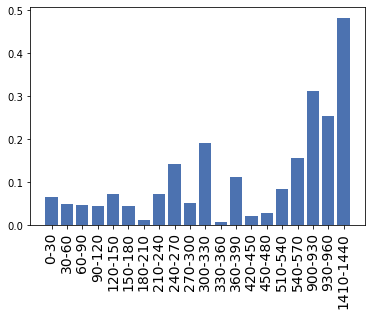

In [125]:
plot_frame(x_alph, y_alph)

**UserKNNCF**

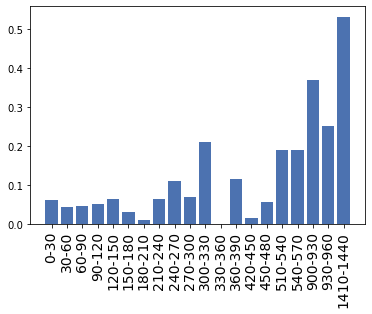

In [69]:
plot_frame(x_ucf, y_ucf)

**SlimBPR**

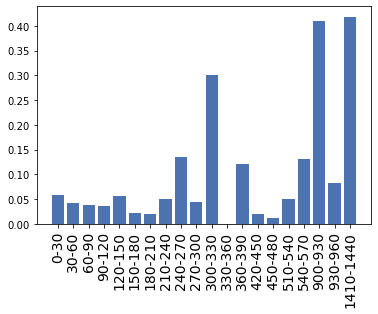

In [64]:
plot_frame(x_slb, y_slb)

**PureSVD**

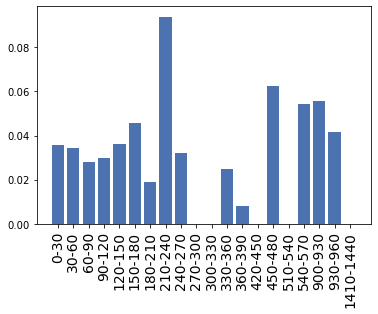

In [60]:
plot_frame(x_pp, y_pp)

**Matrix Factorization BPR**

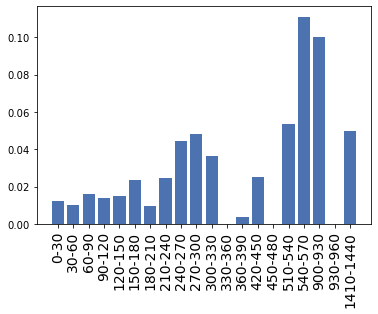

In [56]:
plot_frame(x_mf, y_mf)

#### ItemKNNCBF

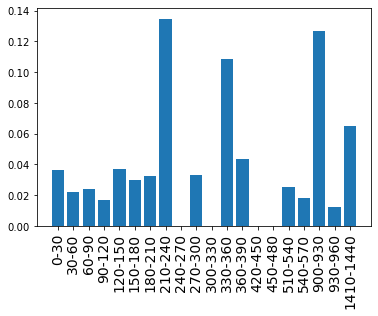

In [18]:
plot_frame(x_knn,y_knn)

#### ItemKNNCF

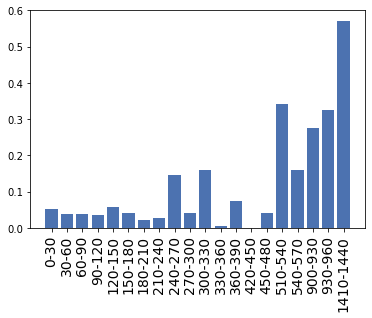

In [51]:
plot_frame(x_cf,y_cf)

#### SLIM ELASTICNET

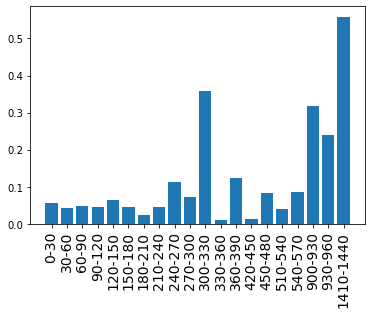

In [41]:
plot_frame(x_slim,y_slim)

#### PageRank

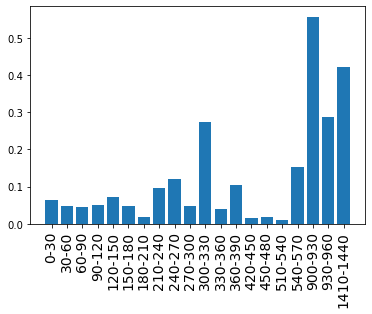

In [38]:
plot_frame(x_apr,y_apr)

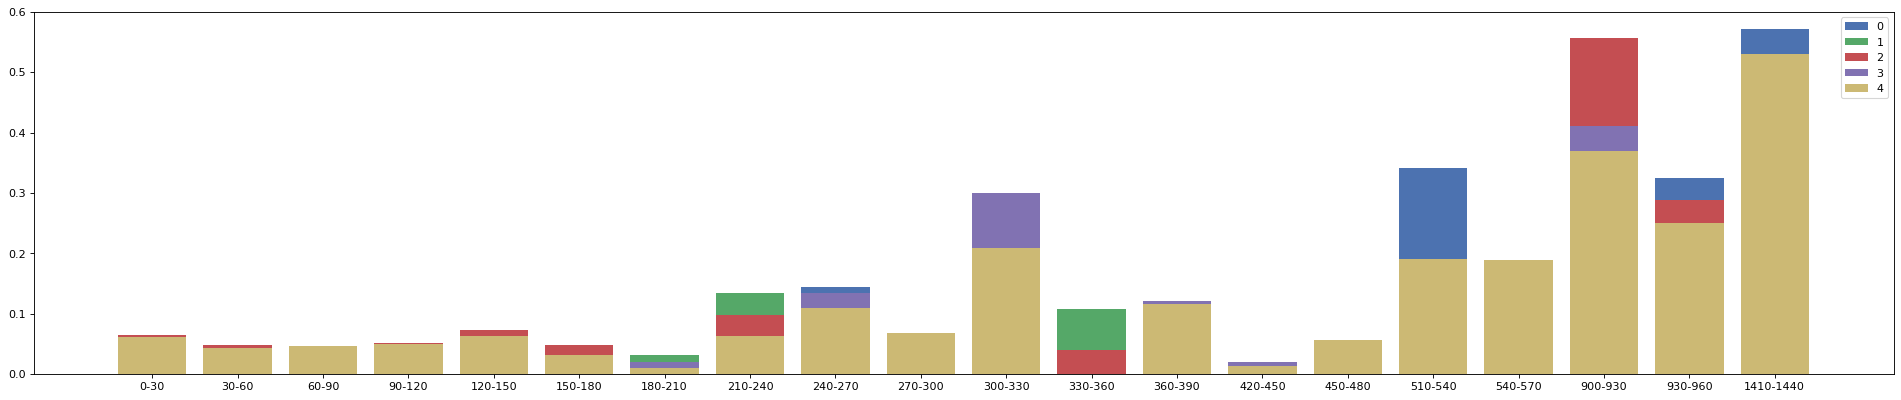

In [133]:
maps = [(x_mf, y_mf), (x_slim,y_slim), (x_cf,y_cf), (x_knn,y_knn), (x_apr,y_apr), (x_pp, y_pp), (x_slb, y_slb), (x_ucf, y_ucf), (x_alph, y_alph)]
maps = [(x_cf,y_cf), (x_knn,y_knn), (x_apr,y_apr), (x_slb, y_slb), (x_ucf, y_ucf)]
multiplot_frame(maps)

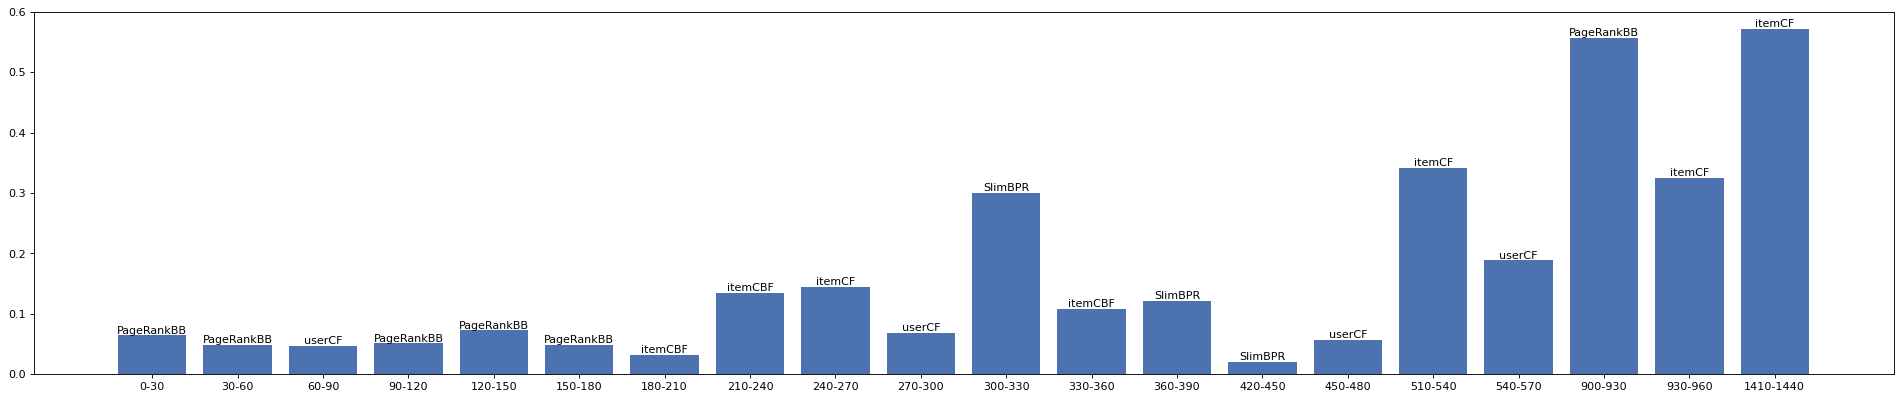

In [132]:
maps = [(x_mf, y_mf), (x_slim,y_slim), (x_cf,y_cf), (x_knn,y_knn), (x_apr,y_apr), (x_pp, y_pp), (x_slb, y_slb), (x_ucf, y_ucf), (x_alph, y_alph)]
maps = [(x_cf,y_cf), (x_knn,y_knn), (x_apr,y_apr), (x_slb, y_slb), (x_ucf, y_ucf)]
y_max, c = max_rec_map(maps)
maps = [(x_cf,y_max,c)]
multiplot_frame2(maps)

In [63]:
result_eval, _ = evaluator_test.evaluateRecommender(rec1)
result_eval[10]['MAP']

EvaluatorHoldout: Processed 5002 ( 100.00% ) in 2.67 sec. Users per second: 1871


0.03492096280031698

In [65]:
result_eval, _ = evaluator_test.evaluateRecommender(rec_elasticnet)
result_eval[10]['MAP']

EvaluatorHoldout: Processed 5002 ( 100.00% ) in 2.94 sec. Users per second: 1704


0.05483607952006887

In [19]:
result_eval, _ = evaluator_test.evaluateRecommender(recommender_apr)
result_eval[10]['MAP']

EvaluatorHoldout: Processed 5002 ( 100.00% ) in 2.67 sec. Users per second: 1871


0.06227232563764613

---

In [4]:
from GraphBased.RP3betaRecommender import RP3betaRecommender
recommender_apr_1 = RP3betaRecommender(URM_train)
recommender_apr_1.fit(alpha=0.4530815441932864,  beta=0.008742088319964482, topK=104, normalize_similarity=False)

RP3betaRecommender: URM Detected 42 (0.53 %) cold users.
RP3betaRecommender: URM Detected 1971 (7.59 %) cold items.


In [5]:
recommender_apr_2 = RP3betaRecommender(URM_train)
#topK': 946, 'alpha': 0.47193263239089045, 'beta': 0.0316773658685341, 'normalize_similarity': False
recommender_apr_2.fit(alpha=0.47193263239089045,  beta=0.0316773658685341, topK=946, normalize_similarity=False)

RP3betaRecommender: URM Detected 42 (0.53 %) cold users.
RP3betaRecommender: URM Detected 1971 (7.59 %) cold items.


In [6]:
result_eval_1, _ = evaluator_test.evaluateRecommender(recommender_apr_1)
'1',result_eval_1[10]['MAP']

EvaluatorHoldout: Processed 5002 ( 100.00% ) in 2.69 sec. Users per second: 1861


('1', 0.06227232563764613)

In [7]:
result_eval_2, _ = evaluator_test.evaluateRecommender(recommender_apr_2)
'2',result_eval_1[10]['MAP']

EvaluatorHoldout: Processed 5002 ( 100.00% ) in 3.09 sec. Users per second: 1620


('2', 0.06227232563764613)